In [3]:
import os
from pathlib import Path
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

Configurations for Model tuning.

In [4]:
# Paths
# adjust path if notebook is elsewhere
PC = True
if PC:
    DATA_RAW = Path(r"D:\Programing\Ai_Music_Tagging\data\genres_original")
    DATA_PROCESSED = Path(r"D:\Programing\Ai_Music_Tagging\data\processed")
else:
    DATA_RAW = Path(
        r"C:\Users\lamka\Documents\School_Work\FIT1049\Ai_Music_Tagging\data\genres_original")
    DATA_PROCESSED = Path(
        r"C:\Users\lamka\Documents\School_Work\FIT1049\Ai_Music_Tagging\data\processed")

DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# Audio params
SAMPLE_RATE = 22050
SEGMENT_DURATION = 5  # seconds
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048

In [5]:
print(DATA_RAW)
genres = sorted([g.name for g in DATA_RAW.iterdir() if g.is_dir()])
print("Genres:", genres)

# Count files
for g in genres:
    count = len(list((DATA_RAW / g).glob("*.wav")))
    print(f"{g}: {count}")

D:\Programing\Ai_Music_Tagging\data\genres_original
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
blues: 100
classical: 100
country: 100
disco: 100
hiphop: 100
jazz: 100
metal: 100
pop: 100
reggae: 100
rock: 100


Preprocessing 

In [6]:
def preprocess_file(filepath, genre):
    # Load audio
    y, sr = librosa.load(filepath, sr=SAMPLE_RATE, mono=True)

    samples_per_segment = SEGMENT_DURATION * SAMPLE_RATE
    total_segments = len(y) // samples_per_segment

    saved_files = []
    for i in range(total_segments):
        start = i * samples_per_segment
        end = start + samples_per_segment
        segment = y[start:end]

        # Compute Mel spectrogram
        mel = librosa.feature.melspectrogram(
            y=segment,
            sr=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Normalize to [-1,1]
        mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-9)

        # Save
        out_dir = DATA_PROCESSED / genre
        out_dir.mkdir(parents=True, exist_ok=True)
        out_name = f"{filepath.stem}_seg{i}.npy"
        np.save(out_dir / out_name, mel_db)
        saved_files.append(out_dir / out_name)

    return saved_files

File test

In [7]:
test_file = list((DATA_RAW / genres[0]).glob("*.wav"))[0]
saved = preprocess_file(test_file, genres[0])
print("Saved segments:", saved)

Saved segments: [WindowsPath('D:/Programing/Ai_Music_Tagging/data/processed/blues/blues.00000_seg0.npy'), WindowsPath('D:/Programing/Ai_Music_Tagging/data/processed/blues/blues.00000_seg1.npy'), WindowsPath('D:/Programing/Ai_Music_Tagging/data/processed/blues/blues.00000_seg2.npy'), WindowsPath('D:/Programing/Ai_Music_Tagging/data/processed/blues/blues.00000_seg3.npy'), WindowsPath('D:/Programing/Ai_Music_Tagging/data/processed/blues/blues.00000_seg4.npy'), WindowsPath('D:/Programing/Ai_Music_Tagging/data/processed/blues/blues.00000_seg5.npy')]


Plot Spectogram

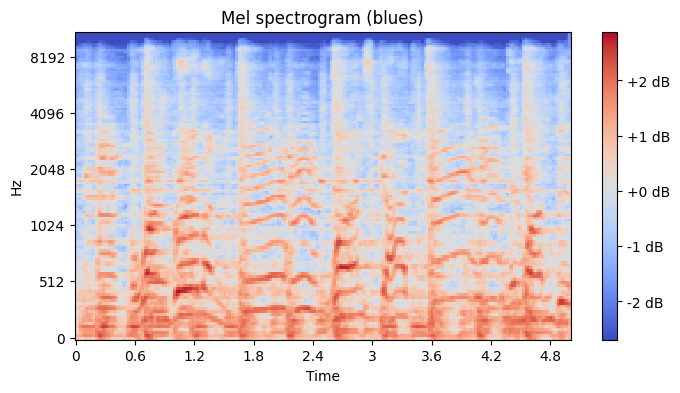

In [8]:
mel_db = np.load(saved[0])
plt.figure(figsize=(8, 4))
librosa.display.specshow(mel_db, sr=SAMPLE_RATE,
                         hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel spectrogram ({genres[0]})")
plt.show()

In [9]:
for genre in genres:
    files = list((DATA_RAW / genre).glob("*.wav"))
    for f in tqdm(files, desc=genre):
        try:
            preprocess_file(f, genre)
        except Exception as e:
            print(f"Failed: {f}, {e}")

jazz:  53%|█████▎    | 53/100 [00:02<00:02, 17.68it/s]C:\Users\kz\AppData\Local\Temp\ipykernel_10636\428568043.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=SAMPLE_RATE, mono=True)
d:\Programing\Ai_Music_Tagging\venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
jazz:  56%|█████▌    | 56/100 [00:03<00:02, 16.84it/s]

Failed: D:\Programing\Ai_Music_Tagging\data\genres_original\jazz\jazz.00054.wav, 


rock: 100%|██████████| 100/100 [00:05<00:00, 18.44it/s]
